# Suppl. Fig. 11 panel E

please first run dependency notebooks in the following directories:
- Fig5/panel_A/1.infected_enrichment
- Fig5/panel_A/2.control_enrichment
- Fig5/panel_A/3.aligned_umap
- Fig5/panel_C/Fig5_C_umap_with_leiden_labels.ipynb

In [1]:
import os, sys
from pathlib import Path
import numpy as np
import pandas as pd
import umap
from scipy.spatial import procrustes
import matplotlib.pyplot as plt
from adjustText import adjust_text
from matplotlib.lines import Line2D

script_path = Path.cwd().parent.parent.parent  / "script"
data_path = Path.cwd().parent.parent.parent  / "data"
sys.path.append(str(script_path))

from pyseus.plotting import plotly_umap as pu
from utils import *

output_folder = Path.cwd() / "output"
os.makedirs(output_folder, exist_ok=True)

In [2]:
%store -r fig5_timestamp
print(f"Timestamp: {fig5_timestamp}")

Timestamp: 2023-10-21-for-figures


## project the virus proteins onto the aligned umap


### make a new umap using virus proteins + infected samples

In [3]:
# prepare data
# read the aligned UMAP
merged = pd.read_csv(Path.cwd().parent.parent / "Fig5" / "panel_A" / "3.aligned_umap" / "output" / "2023-10-21-for-figures_AlignedUMAP_embeddings_and_distances.csv", index_col=None)

# read the virus proteins
virus_df_raw = pd.read_csv(Path.cwd().parent.parent / "Fig5" / "panel_A" / "1.infected_enrichment" / "output" / "enrichment_and_volcano_tables" /"2023-10-21-for-figures_inf_enrichment_table_NOC_prop.csv",  header=[0, 1], index_col=0, low_memory=False)
virus_df = virus_df_raw.droplevel(0, axis=1)
print(f"enrichment_table_NOC dimensions:\n{virus_df.shape}")
# subset the virus df, keeping virus protein + proteins in the aligned UMAP
virus_df = virus_df[ (virus_df["Majority protein IDs"].isin(merged["Majority protein IDs"]))
                     | (virus_df["Protein IDs"].str.contains("OC43"))]
# save a copy of the virus_df
virus_df.to_csv(output_folder / f"{fig5_timestamp}_quants_with_virus.csv")

print(f'after keeping proteins in the aligned umap and virus proteins:\n{virus_df.shape}')
# subset the virus df, keeping the infected samples and their NOCs
inf = [i for i in merged.columns if i.endswith("_Infected")]
virus_df = virus_df[inf]
print(f'after keeping infected samples:\n{virus_df.shape}')
# scale the table for umap
virus_scaled = pu.scale_table(matrix=virus_df.copy().fillna(0).to_numpy(), method='standard')
print(f"virus_scaled shape:\n{virus_scaled.shape}")

enrichment_table_NOC dimensions:
(8376, 51)
after keeping proteins in the aligned umap and virus proteins:
(8037, 51)
after keeping infected samples:
(8037, 28)
virus_scaled shape:
(8037, 28)


In [4]:
# make a umap using infected samples + the virus proteins
virus_umap = umap.UMAP(n_neighbors=20,
                        metric="euclidean",
                        min_dist=0.1,
                        n_components = 2,
                        random_state=42,    
                        verbose = False).fit_transform(virus_scaled)
virus_df["Protein IDs"] = virus_df_raw.droplevel(0, axis=1)["Protein IDs"]
virus_df["Majority protein IDs"] = virus_df_raw.droplevel(0, axis=1)["Majority protein IDs"]
virus_df["Gene names"] = virus_df_raw.droplevel(0, axis=1)["Gene names"]
virus_df["umap_1"] = list(virus_umap[:, 0])
virus_df["umap_2"] = list(virus_umap[:, 1])

# save the virus umap to file
virus_df.to_csv(output_folder / f"umap_with_virus_proteins.csv")

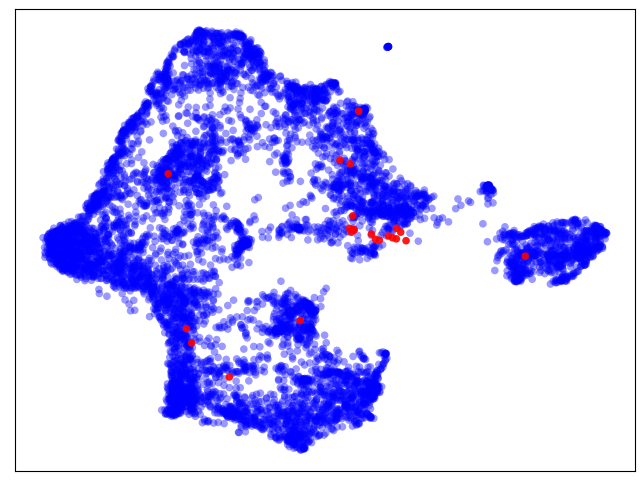

In [5]:
# visualize the umap made with infected samples + the virus proteins

# add a column where the virus proteins are labeled
virus_df["protein_source"] = virus_df["Protein IDs"].apply(lambda x: "OC43_protein" if "OC43" in x else "host_protein")

virus_only = virus_df[virus_df["Protein IDs"].str.contains("OC43")]
host_only = virus_df[~virus_df["Protein IDs"].str.contains("OC43")]

# Plot the two embeddings as scatter plots
colorDict = {"OC43_protein": "red", "host_protein": "blue"}
plt.rcParams["pdf.fonttype"] = 42
fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(
    host_only["umap_1"], host_only["umap_2"],
    c=[colorDict[cat] for cat in host_only[f"protein_source"]],
    s=120, alpha=0.4, label="uninfected", marker=".", linewidths=0, edgecolor=None,
)
ax.scatter(
    virus_only["umap_1"], virus_only["umap_2"],
    c=[colorDict[cat] for cat in virus_only[f"protein_source"]],
    s=120, alpha=0.9, label="uninfected", marker=".", linewidths=0, edgecolor=None,
)
ax.xaxis.set_major_formatter(plt.NullFormatter())
ax.yaxis.set_major_formatter(plt.NullFormatter())
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
plt.savefig(os.path.join("output", "inf_umap_colored_by_GO_CC.pdf"), format="pdf")
plt.show()

### adjust the range of the new umap coordinates to match that of the aligned umap (in preparation for projection)

In [6]:
# range of the new umap coordinates (with virus proteins)  
print(f"range of umap coordinates (inf + virus proteins):\n{virus_df['umap_1'].min(), virus_df['umap_1'].max()}")
print(f"{virus_df['umap_2'].min(), virus_df['umap_2'].max()}")


range of umap coordinates (inf + virus proteins):
(-4.855353, 7.1967745)
(-2.0159981, 8.571013)


range of umap coordinates (aligned, infection side):
(-6.7988577, 6.173023)
(-5.930825, 5.452529)


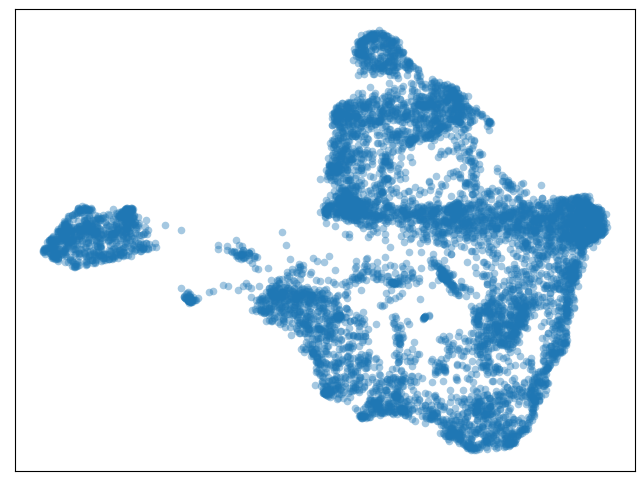

In [7]:
# range of alignedUMAP_coords (infected)

jointUMAP_inf_1 = merged["JointUMAP_inf_1"]
jointUMAP_inf_2 = merged["JointUMAP_inf_2"]

jointUMAP_uninf_1 = merged["JointUMAP_uninf_1"]
jointUMAP_uninf_2 = merged["JointUMAP_uninf_2"]

# range of umap coordinates
print(f"range of umap coordinates (aligned, infection side):\n{min(jointUMAP_inf_1), max(jointUMAP_inf_1)}")
print(f"{min(jointUMAP_inf_2), max(jointUMAP_inf_2)}")

# plot the aligned UMAP to check if we need to flip the coordindates
fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(
    merged["JointUMAP_inf_1"] , merged["JointUMAP_inf_2"],
    s=120, alpha=0.4, label="uninfected", marker=".", linewidths=0, edgecolor=None,
)
ax.xaxis.set_major_formatter(plt.NullFormatter())
ax.yaxis.set_major_formatter(plt.NullFormatter())
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
plt.savefig(os.path.join("output", "inf_umap_colored_by_GO_CC.pdf"), format="pdf")
plt.show()

# NOTE: need to flip the axes


In [8]:
# flip the axes and check the range again
flip = True
if flip == True:
    jointUMAP_inf_1 = [-i for i in jointUMAP_inf_1]
    jointUMAP_inf_2 = [-i for i in jointUMAP_inf_2]
    jointUMAP_uninf_1 = [-i for i in jointUMAP_uninf_1]
    jointUMAP_uninf_2 = [-i for i in jointUMAP_uninf_2]

print(f"range of umap coordinates (aligned, infection side):\n{min(jointUMAP_inf_1), max(jointUMAP_inf_1)}")
print(f"{min(jointUMAP_inf_2), max(jointUMAP_inf_2)}")

range of umap coordinates (aligned, infection side):
(-6.173023, 6.7988577)
(-5.452529, 5.930825)


In [9]:
# adjust the range of the jointUMAP coordinates to match the range of the virus umap coordinates
def rescale_list(input_list, original_min, original_max, desired_min, desired_max):
    return [desired_min + ((x - original_min) * (desired_max - desired_min) / (original_max - original_min)) for x in input_list]


jointUMAP_inf_1_rescale = rescale_list(jointUMAP_inf_1, min(jointUMAP_inf_1), max(jointUMAP_inf_1), virus_df['umap_1'].min(), virus_df['umap_1'].max())
jointUMAP_inf_2_rescale = rescale_list(jointUMAP_inf_2, min(jointUMAP_inf_2), max(jointUMAP_inf_2), virus_df['umap_2'].min(), virus_df['umap_2'].max())
jointUMAP_uninf_1_rescale = rescale_list(jointUMAP_uninf_1, min(jointUMAP_uninf_1), max(jointUMAP_uninf_1), virus_df['umap_1'].min(), virus_df['umap_1'].max())
jointUMAP_uninf_2_rescale = rescale_list(jointUMAP_uninf_2, min(jointUMAP_uninf_2), max(jointUMAP_uninf_2), virus_df['umap_2'].min(), virus_df['umap_2'].max())

print(f"range of umap coordinates (aligned, infection side):\n{min(jointUMAP_inf_1_rescale), max(jointUMAP_inf_1_rescale)}")
print(f"{min(jointUMAP_inf_2_rescale), max(jointUMAP_inf_2_rescale)}")
print(f"range of umap coordinates (aligned, uninfected side):\n{min(jointUMAP_uninf_1_rescale), max(jointUMAP_uninf_1_rescale)}")
print(f"{min(jointUMAP_uninf_2_rescale), max(jointUMAP_uninf_2_rescale)}")


range of umap coordinates (aligned, infection side):
(-4.855352878570557, 7.196774959564209)
(-2.015998125076294, 8.57101321220398)
range of umap coordinates (aligned, uninfected side):
(-4.855352878570557, 7.196774959564209)
(-2.015998125076294, 8.57101321220398)


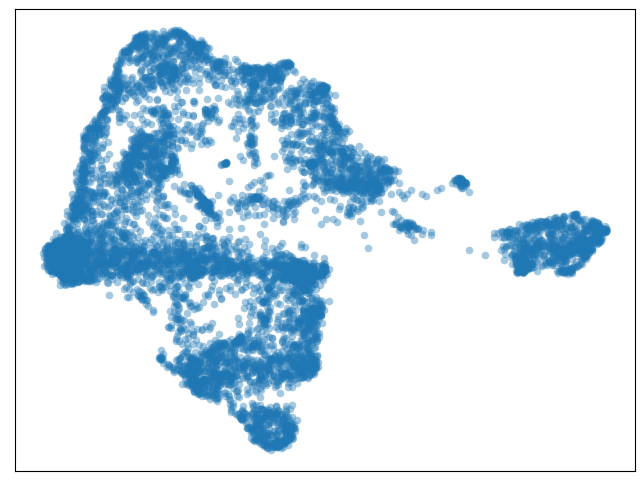

In [10]:
# plot the flipped and rescaled infected alignedUMAP_coords
fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(
    jointUMAP_inf_1_rescale, jointUMAP_inf_2_rescale,
    s=120, alpha=0.4, label="uninfected", marker=".", linewidths=0, edgecolor=None,
)
ax.xaxis.set_major_formatter(plt.NullFormatter())
ax.yaxis.set_major_formatter(plt.NullFormatter())
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
plt.savefig(os.path.join("output", "inf_umap_colored_by_GO_CC.pdf"), format="pdf")
plt.show()

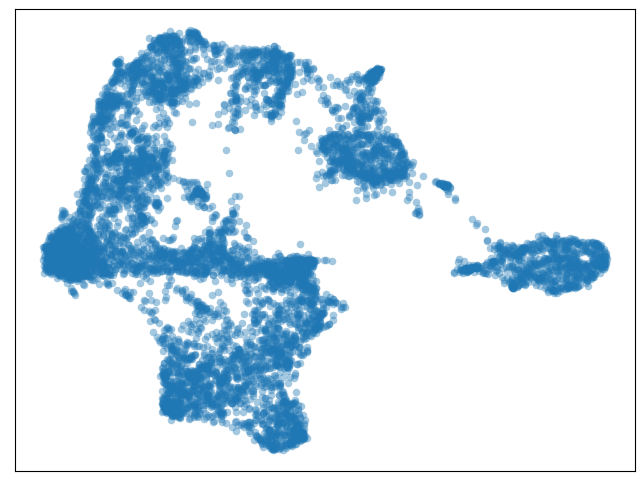

In [11]:
# plot alignedUMAP_coords (uninfected)
fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(
    jointUMAP_uninf_1_rescale, jointUMAP_uninf_2_rescale,
    s=120, alpha=0.4, label="uninfected", marker=".", linewidths=0, edgecolor=None,
)
ax.xaxis.set_major_formatter(plt.NullFormatter())
ax.yaxis.set_major_formatter(plt.NullFormatter())
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
plt.savefig(os.path.join("output", "inf_umap_colored_by_GO_CC.pdf"), format="pdf")
plt.show()

# NOTE: need to flip the axes


In [12]:
# save aligned umap embeddings to csv

merged["JointUMAP_uninf_1"] = jointUMAP_uninf_1_rescale
merged["JointUMAP_uninf_2"] = jointUMAP_uninf_2_rescale
merged["JointUMAP_inf_1"] = jointUMAP_inf_1_rescale
merged["JointUMAP_inf_2"] = jointUMAP_inf_2_rescale

# update coordinates
save_path = output_folder / f"{fig5_timestamp}_AlignedUMAP_embeddings_and_distances.csv"
merged.to_csv(save_path, index=False)

### compute the projection of virus proteins onto the aligned umap (infection side)

In [13]:
# perform Procrustes analysis to find the best projection
shared_proteins = merged["Protein IDs"].to_list()


alignedUMAP_coords = np.array([jointUMAP_inf_1_rescale,
                               jointUMAP_inf_2_rescale]).T
virus_umap_common = virus_df[virus_df["Protein IDs"].isin(shared_proteins)] # get the common proteins to compute the projection (can't have virus proteins in this step)
virus_umap_coords = np.array([virus_umap_common['umap_1'], 
                              virus_umap_common['umap_2']]).T

# Function to compute transformation using Procrustes analysis
def compute_transformation(UMAP1_common, UMAP2_common):
    # Perform Procrustes analysis
    mtx1, mtx2, disparity = procrustes(UMAP1_common, UMAP2_common)
    
    # Compute the transformation matrix
    translation = np.mean(mtx1, axis=0) - np.mean(mtx2, axis=0)
    scale = np.std(mtx1) / np.std(mtx2)
    
    # Compute the rotation matrix
    rotation_matrix = np.linalg.lstsq(mtx2, mtx1, rcond=None)[0]
    
    return translation, scale, rotation_matrix

# Function to compute transformation using Procrustes analysis
def compute_transformation_v2(UMAP1_common, UMAP2_common):
    # Perform Procrustes analysis
    mtx1, mtx2, disparity = procrustes(UMAP1_common, UMAP2_common)
    
    # Calculate the optimal rotation matrix using SVD
    U, _, Vt = np.linalg.svd(mtx2.T @ mtx1)
    rotation_matrix = U @ Vt
    
    # Calculate scaling and translation
    scale = np.std(mtx1) / np.std(mtx2)
    translation = np.mean(mtx1, axis=0) - scale * np.mean(mtx2 @ rotation_matrix, axis=0)
    
    return translation, scale, rotation_matrix

# Perform Procrustes analysis to find the best transformation
# we are using the alignedUMAP(infected) as the reference, and the virus umap will be transformed to fit into the reference 
translation, scale, rotation_matrix = compute_transformation(alignedUMAP_coords, virus_umap_coords)

In [14]:
# project the virus proteins using the transformation 
# Apply the transformation to the extra points
def apply_transformation(points, translation, scale, rotation_matrix):
    # Apply rotation and scaling
    transformed_points = points @ rotation_matrix * scale
    
    # Apply translation
    transformed_points += translation
    
    return transformed_points

virus_points = virus_df[virus_df["Protein IDs"].str.contains("OC43")].copy()
virus_points_coords = virus_points[["umap_1", "umap_2"]].to_numpy()
virus_points_projected = apply_transformation(virus_points_coords, translation, scale, rotation_matrix)

virus_points["umap_1_projected"] = virus_points_projected[:, 0]
virus_points["umap_2_projected"] = virus_points_projected[:, 1]

In [15]:
virus_points_temp = virus_points.copy()[["Protein IDs", "Majority protein IDs", "Gene names", "umap_1_projected", "umap_2_projected"]]
# rename the projected columns as joint UMAP infected 
virus_points_temp.rename(columns={"umap_1_projected": "JointUMAP_inf_1", "umap_2_projected": "JointUMAP_inf_2"}, inplace=True)
# add dummy columns for the joint UMAP uninfected
virus_points_temp["JointUMAP_uninf_1"] = 0
virus_points_temp["JointUMAP_uninf_2"] = 0

In [16]:
# add virus proteins to the aligned umap
merged_with_virus = merged.copy()
merged_with_virus = merged_with_virus[["Protein IDs", "Majority protein IDs", "Gene names"]] # keep the metadata
merged_with_virus["JointUMAP_uninf_1"] = jointUMAP_uninf_1_rescale # add aligned umap coordinates
merged_with_virus["JointUMAP_uninf_2"] = jointUMAP_uninf_2_rescale
merged_with_virus["JointUMAP_inf_1"] = jointUMAP_inf_1_rescale
merged_with_virus["JointUMAP_inf_2"] = jointUMAP_inf_2_rescale


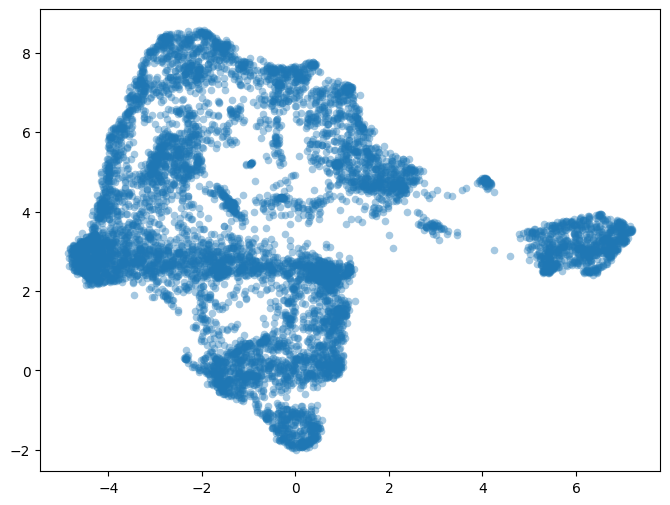

In [17]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(
    merged_with_virus["JointUMAP_inf_1"], merged_with_virus["JointUMAP_inf_2"],
    s=120, alpha=0.4, label="uninfected", marker=".", linewidths=0, edgecolor=None,
)
plt.show()

In [18]:
# add the virus proteins to the merged umap by concatenating the two dataframes
merged_with_virus = pd.concat([merged_with_virus, virus_points_temp], ignore_index=True)

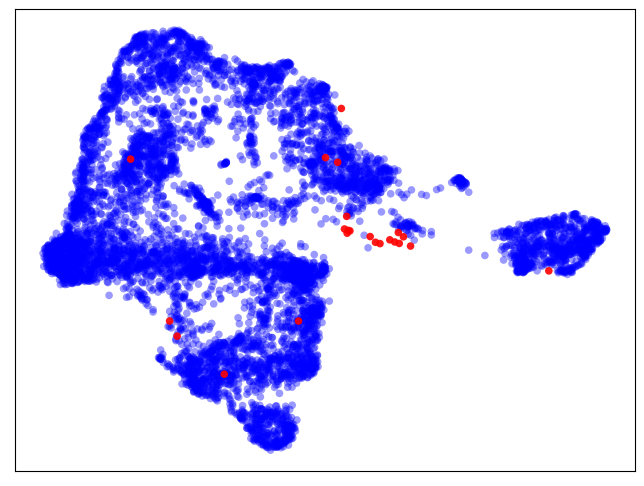

In [19]:
# visualize the aligned UMAP with the virus proteins
merged_with_virus["protein_source"] = merged_with_virus["Protein IDs"].apply(lambda x: "OC43_protein" if "OC43" in x else "host_protein")
virus_only = merged_with_virus[merged_with_virus["Protein IDs"].str.contains("OC43")]
host_only = merged_with_virus[~merged_with_virus["Protein IDs"].str.contains("OC43")]

# Plot the two embeddings as scatter plots
colorDict = {"OC43_protein": "red", "host_protein": "blue"}
plt.rcParams["pdf.fonttype"] = 42
fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(
    host_only["JointUMAP_inf_1"], host_only["JointUMAP_inf_2"],
    c=[colorDict[cat] for cat in host_only[f"protein_source"]],
    s=120, alpha=0.4, label="uninfected", marker=".", linewidths=0, edgecolor=None,
)
ax.scatter(
    virus_only["JointUMAP_inf_1"], virus_only["JointUMAP_inf_2"],
    c=[colorDict[cat] for cat in virus_only[f"protein_source"]],
    s=120, alpha=0.9, label="uninfected", marker=".", linewidths=0, edgecolor=None,
)
ax.xaxis.set_major_formatter(plt.NullFormatter())
ax.yaxis.set_major_formatter(plt.NullFormatter())
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
plt.savefig(os.path.join("output", "inf_umap_colored_by_GO_CC.pdf"), format="pdf")
plt.show()

### save the aligned umap (now with projected virus proteins)

In [20]:
merged_with_virus

,Protein IDs,Majority protein IDs,Gene names,JointUMAP_uninf_1,JointUMAP_uninf_2,JointUMAP_inf_1,JointUMAP_inf_2,protein_source
0,A0A023T6R1;Q96A72;F5H6P7;F5H6N1;F5H3U9;F5H124,A0A023T6R1;Q96A72;F5H6P7;F5H6N1,FLJ10292;MAGOHB,0.868295,1.167910,0.542081,1.497523,host_protein
1,Q9Y5S9;A0A023T787;A0A0J9YW13,Q9Y5S9;A0A023T787,RBM8A;RBM8,-1.523145,0.143475,-0.246086,0.003211,host_protein
2,A0A0C4DFM1;A0A024QYR3;Q92544;B4DH88;B4DKC1;Q6Z...,A0A0C4DFM1;A0A024QYR3;Q92544;B4DH88;B4DKC1;Q6ZTK5,TM9SF4,2.165244,7.397985,0.964936,7.046222,host_protein
3,A0A024QYR6;A0A1V0DNR7;A0A6G6A825;F6KD02;F6KD01...,A0A024QYR6;A0A1V0DNR7;A0A6G6A825;F6KD02;F6KD01...,PTEN,-4.441446,3.110756,-2.890606,2.939813,host_protein
4,Q99805;A0A024QYR8;B3KSG9,Q99805;A0A024QYR8;B3KSG9,TM9SF2,1.434770,7.285963,0.736803,6.761136,host_protein
...,...,...,...,...,...,...,...,...
8032,OC43_ORF1AB_GN7MT,OC43_ORF1AB_GN7MT,NaN,0.000000,0.000000,1.590142,3.558438,OC43_protein
8033,OC43_ORF1AB_HEL,OC43_ORF1AB_HEL,NaN,0.000000,0.000000,1.647442,3.452376,OC43_protein
8034,OC43_ORF1AB_RDRP,OC43_ORF1AB_RDRP,NaN,0.000000,0.000000,2.559570,3.285538,OC43_protein
8035,OC43_ORF1AB_USE,OC43_ORF1AB_USE,NaN,0.000000,0.000000,2.139213,3.367196,OC43_protein


In [21]:
# save the merged umap with virus proteins to file
merged_with_virus.to_csv(output_folder / f"{fig5_timestamp}_AlignedUMAP_embeddings_with_virus_proteins_projections.csv")

In [22]:
# create a subset of virus proteins only
virus_proteins_umap_table = merged_with_virus[merged_with_virus["Protein IDs"].str.contains("OC43")]

## Plot the aligned umap (infected side) with projected virus proteins

In [23]:
# read the aligned UMAP (with leiden clusters)
df = pd.read_csv(Path.cwd().parent.parent / "Fig5" / "panel_C" / "output" / f"{fig5_timestamp}_umap_table.csv", index_col=None)

# update the coordinates with once that were recentered
df["JointUMAP_inf_1"] = host_only["JointUMAP_inf_1"]
df["JointUMAP_inf_2"] = host_only["JointUMAP_inf_2"]

In [24]:
# define cluster colors
colorDict = {
    "nucleus": "#DB5F57",
    "cytosol": "#A2CE5A",
    "mitochondrion": "#59B6DC",
    "ER": "#DB9C58",
    "plasma memb. & actin": "#B96EAD",
    "endo-lysosome & trans-Golgi": "#DBD956",
    "ERGIC/Golgi": "#6BC7BB",
    "translation/RNA granules": "#414042",
    "peroxisome": "#EC008C",
    "COPI vesicle": "red",
    "centrosome": "#955FA7",
    "unlabelled": "grey",
    "OC43_protein":"#03fceb",
    "unclassified": "#cccccc"
}

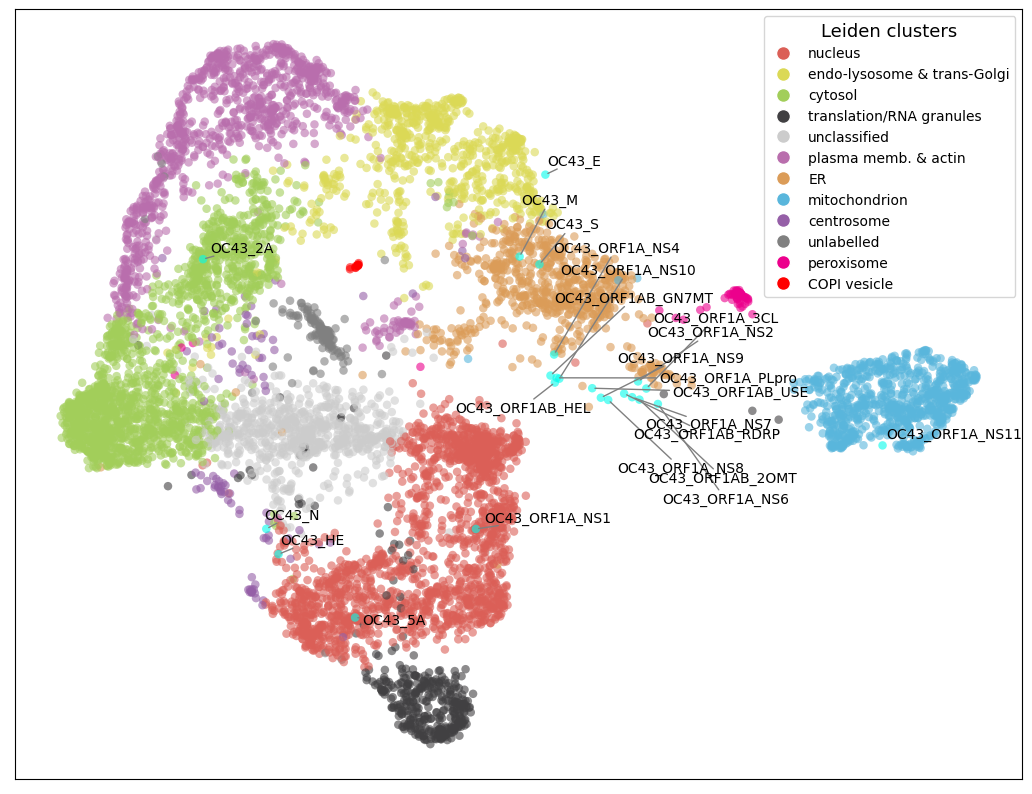

In [25]:
# Plot

# plot host proteins
plt.rcParams["pdf.fonttype"] = 42
fig, ax = plt.subplots(figsize=(13, 10))
ax.scatter(
    df["JointUMAP_inf_1"], df["JointUMAP_inf_2"],
    c=[colorDict[cat] for cat in df[f"cluster_annot_inf"]],
    s=150, alpha=0.6, label="uninfected", marker=".", linewidths=0, edgecolor=None,
)

# plot virus proteins
ax.scatter(
    virus_proteins_umap_table["JointUMAP_inf_1"], virus_proteins_umap_table["JointUMAP_inf_2"],
    c=[colorDict[cat] for cat in virus_proteins_umap_table[f"protein_source"]],
    s=150, alpha=0.6, label="uninfected", marker=".", linewidths=0, edgecolor=None,
)
x = virus_proteins_umap_table["JointUMAP_inf_1"].tolist()
y = virus_proteins_umap_table["JointUMAP_inf_2"].tolist()
labels = virus_proteins_umap_table["Protein IDs"].tolist()

# Handle duplicated virus names by adding a suffix
seen = {}
for i in range(len(labels)):
    item = labels[i]
    if item not in seen:
        seen[item] = 1
    else:
        seen[item] += 1
        labels[i] = f"{item}_{seen[item]}"
# Add text labels to the plot
texts = []
for i in range(len(x)):
    texts.append(ax.text(x[i], y[i], labels[i], fontsize=10))
# Adjust text labels to avoid overlap
adjust_text(texts, only_move={'points':'y', 'text':'y'}, arrowprops=dict(arrowstyle='-', color='gray'),
            force_text=0.5,
            expand =(1.2, 1.4), 
 )

# Create a custom legend
unique_categories = df[f"cluster_annot_inf"].unique()
legend_handles = [
    Line2D([0], [0], marker='o', color='w', label=cat, 
           markersize=10, markerfacecolor=colorDict[cat])
    for cat in unique_categories
]
ax.legend(handles=legend_handles, title="Leiden clusters", loc="best", fontsize=10, title_fontsize='13')

ax.xaxis.set_major_formatter(plt.NullFormatter())
ax.yaxis.set_major_formatter(plt.NullFormatter())
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
plt.savefig(os.path.join("output", "inf_umap_colored_by_GO_CC.pdf"), format="pdf")
plt.show()